* 主要就是，扩大了 maxlen 。表现就能提高很多。
* 文本长度不定长怎么搞。
    * 尝试一下把不同长度的文本分开来搞呢？看看长度和分数的关系情况。然后看看各个长度的表现是多少，看看有哪种是表现比较弱的，我们就分批来训练和预测呗。

In [1]:
import sys
from kaitoupao import *

storage dir: /Users/minkexiu/Downloads/GitHub/Tianchi_NLPNewsClassification
code dir: /Users/minkexiu/Documents/GitHub/Tianchi_NLPNewsClassification 

04 23 40
先天八卦数: 1乾, 2兑, 3离, 4震, 5巽, 6坎, 7艮, 8坤
本卦上：4 本卦下：7 变爻：4


,雷山小过,泽风大过,地山谦
上卦,☳震木,☱兑金,☷坤土
下卦,☶艮土,☴巽木,☶艮土


12 05 1 子时
先天八卦数: 1乾, 2兑, 3离, 4震, 5巽, 6坎, 7艮, 8坤
本卦上：4 本卦下：5 变爻：1


,雷风恒,泽天夬,雷天大壮
上卦,☳震木,☱兑金,☳震木
下卦,☴巽木,☰乾金,☰乾金


In [18]:
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score

In [3]:
device = torch.device("cpu")

# 加载训练集和测试集，将全量字符列表给它弄出来

In [4]:
data_train = pd.read_csv(create_originalData_path("train_set.csv"), sep="\t")
data_test = pd.read_csv(create_originalData_path("test_a.csv"), sep="\t")

In [5]:
data_train.shape, data_test.shape

((200000, 2), (50000, 1))

In [6]:
type_of_class = data_train.label.nunique()

In [7]:
## 看看文本长度吧

In [10]:
def get_text_len(txt):
    return len(txt.strip().split())
data_train["txt_len"] = data_train.text.progress_apply(get_text_len)
data_test["txt_len"] = data_test.text.progress_apply(get_text_len)

100%|██████████████████████████████████| 50000/50000 [00:00<00:00, 66225.24it/s]


In [13]:
data_train["txt_len"].describe()

count    200000.000000
mean        907.207110
std         996.029036
min           2.000000
25%         374.000000
50%         676.000000
75%        1131.000000
max       57921.000000
Name: txt_len, dtype: float64

In [14]:
data_test["txt_len"].describe()

count    50000.000000
mean       909.844960
std       1032.313375
min         14.000000
25%        370.000000
50%        676.000000
75%       1133.000000
max      41861.000000
Name: txt_len, dtype: float64

<Axes: xlabel='txt_len', ylabel='Density'>

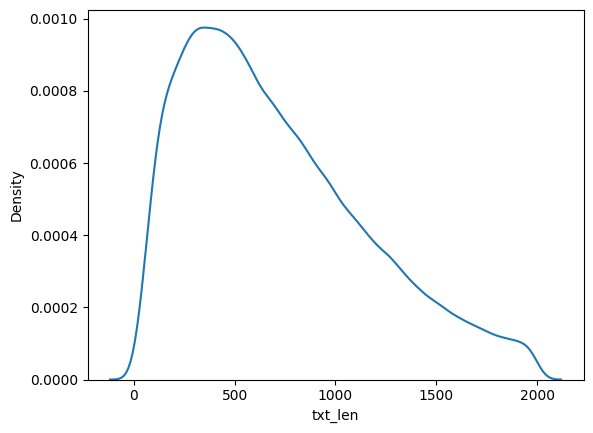

In [24]:
sns.kdeplot(data_train[data_train.txt_len < 2000]["txt_len"])

# 定义网络结构

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(maxlen, embed_dim)

    def forward(self, x):
        maxlen = x.size(1)
        positions = torch.arange(0, maxlen, device=x.device).unsqueeze(0).expand_as(x)
        return self.token_emb(x) + self.pos_emb(positions)

In [ ]:
# 定义模型
class TransformerModel(nn.Module):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim):
        super(TransformerModel, self).__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.Linear(embed_dim, 20)
        self.dropout2 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(20, type_of_class)
        
    def forward(self, x):
        # print(x)
        x = self.embedding_layer(x).transpose(0, 1)  # Transformer expects (seq_len, batch_size, embed_dim)
        x = self.transformer_block(x)
        x = x.transpose(0, 1)
        x = self.global_avg_pool(x.permute(0, 2, 1)).squeeze(-1)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        x = self.dropout2(x)
        return F.log_softmax(self.dense2(x), dim=-1)

# 准备数据集

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(data_train.text, data_train.label, test_size=0.3)

In [ ]:
## 我们对文本的长度有所限定了。

In [ ]:
# 下载数据并进行预处理
vocab_size = 8000  # 只考虑前 20k 词汇
maxlen = 800  # 只考虑每条评论的前 200 个词

In [ ]:
def preprocess_seq_str_2_int(seq, len_lim = maxlen):
    rst = [int(wd) for idx, wd in enumerate(seq.strip().split()) if idx < len_lim]
    return rst

In [ ]:
x_train = [torch.tensor(preprocess_seq_str_2_int(seq), dtype=torch.long) for seq in x_train]
y_train = torch.tensor(list(y_train), dtype=torch.long)
x_valid = [torch.tensor(preprocess_seq_str_2_int(seq), dtype=torch.long) for seq in x_valid]
y_valid = torch.tensor(list(y_valid), dtype=torch.long)

In [ ]:
x_train = pad_sequence(x_train, batch_first=True, padding_value=0)
x_valid = pad_sequence(x_valid, batch_first=True, padding_value=0)

In [ ]:
x_val, y_val = x_valid, y_valid

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
x_oot = [torch.tensor(preprocess_seq_str_2_int(seq), dtype=torch.long) for seq in data_test.text]

x_oot = pad_sequence(x_oot, batch_first=True, padding_value=0)

oot_dataset = TensorDataset(x_oot,)

oot_loader = DataLoader(oot_dataset, batch_size=32)

# 构建模型以及训练

In [ ]:
model = TransformerModel(maxlen, vocab_size, embed_dim=64, num_heads=4, ff_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
model

In [ ]:
# 训练和评估模型
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for inputs, targets in tqdm.tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss/len(train_loader)}, Accuracy: {100.*correct/total}%')
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            total_predicted = []
            total_label = []
            for inputs, targets in tqdm.tqdm(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                total_predicted += list(predicted)
                total_label += list(targets)
        f1 = f1_score(total_label, total_predicted, average='macro')
                
        print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100.*correct/total}%, f1 score is {f1}')

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

In [ ]:
# train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

In [ ]:
# train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

# 预测一下试试

In [ ]:
with torch.no_grad():
    total_predicted = []
    for inputs in tqdm.tqdm(oot_loader):
        outputs = model(inputs[0])
        _, predicted = torch.max(outputs, 1)
        total_predicted += list(predicted)

In [ ]:
oot_rst = [int(x) for x in total_predicted]
len(oot_rst)

In [ ]:
store_data_to_newbasepath(pd.DataFrame({"label": oot_rst}), "rst-20241228", fmt="csv")